# Running a pMSSM scan with mapyde

In this notebook we'll use mapyde to process some pMSSM scan points and plot the results.  We use the full mapyde pipeline:

1. MadGraph for event generation
2. Pythia for hadronization
3. Delphes for detector simulation
4. SimpleAnalysis for analysis selection
5. pyhf to fit a public likelihood with the generated signal yields

The input to this is a collection of SLHA files that define the pMSSM scan points.  These can be generated with your scanning tool of choice.

In [1]:
import mapyde
from mapyde.runner import run_madgraph, run_delphes, run_ana, run_sa2json, run_simpleanalysis, run_pyhf
from mapyde.utils import build_config, load_config

import os
import toml
import json
import urllib
import glob

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

If dask is available, set it up.  (Dask is an easy way to parallelize tasks in python.  We use it to process many scan points in parallel.)  If not, no big deal, the jobs will just take a bit longer running serially.

In [2]:
dask_available=False
try:
    import dask
    from dask.distributed import LocalCluster, Client

    cluster = LocalCluster();
    client = Client(cluster);
    dask_available=True
except ImportError:
    print("Dask is not available, running serially.")

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43401
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33993'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38989'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40479'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43549'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33267'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44757'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44083', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44083
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:37138
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33037', name: 2, status: init, mem

Here's a helper function we'll use to pull particle masses out of SLHA files based on the job configuration.

In [3]:
def get_particle_mass(config,pdg_id):
    SLHAfilename=config["base"]["path"]+"/"+config["base"]["output"]+"/"+config["madgraph"]["params"]+".slha"
    mass=-1
    with open(SLHAfilename,"r") as SLHAfile:
        inmassblock=False
        for line in SLHAfile:
            if "Block MASS" in line:
                inmassblock=True
                continue
            else:
                if inmassblock:
                    if "Block" in line:
                        inmassblock=False
                        continue
                    sline=line.strip().split()
                    if sline[0]=='#':
                        continue
                    elif int(sline[0])==pdg_id:
                        mass=float(line.strip().split()[1])
                        break
                else:
                    continue
    if mass<0:
        print(f"Could not find particle {pdg_id} mass")

    return mass

This retrieves some ATLAS results that we'll use for plotting at the end.  

In [4]:
observed_contour_mass=[]
observed_contour_splitting=[]
# Higgsinos: 14a
# Sleptons: 16a
with urllib.request.urlopen('https://www.hepdata.net/download/table/ins1767649/Figure%2014a%20Observed/4/csv') as response:
    for line in response:
        sline=line.decode("utf-8") 
        if sline[0]=='#' or sline[0]=='$': continue
        if len(sline.strip())==0: continue
        observed_contour_mass.append(float(sline.split(',')[0]))
        observed_contour_splitting.append(float(sline.split(',')[1]))

expected_contour_mass=[]
expected_contour_splitting=[]
# Higgsinos: 14a
# Sleptons: 16a
with urllib.request.urlopen('https://www.hepdata.net/download/table/ins1767649/Figure%2014a%20Expected/4/csv') as response:
    for line in response:
        sline=line.decode("utf-8") 
        if sline[0]=='#' or sline[0]=='$': continue
        if len(sline.strip())==0: continue
        expected_contour_mass.append(float(sline.split(',')[0]))
        expected_contour_splitting.append(float(sline.split(',')[1]))

## Setting up the mapyde jobs

These are several helper functions for creating configs or reading existing configs.  (Note we run with MPI turned off in pythia to save time -- for better accuracy, turn it on!)  This is where the information about the SLHA card is injected...  we provide the card under:

```config["base"]["param_path"]/config["madgraph"]["params"].slha```

In [5]:
def create_config(scanpoint=4305333):
    return mapyde.utils.build_config(toml.loads(f"""
[base]
path = "/home/jupyter-mhance/mario-mapyde-user/pmssm"
output = "SUSY_{scanpoint}"
template = "{{{{PWD}}}}/templates/ewkinos.toml"
process_path = "{{{{PWD}}}}/cards/process/"
param_path = "{{{{PWD}}}}/cards/param/"

[madgraph]
params="{scanpoint}.spheno"
nevents=10000
keep_output=false

[madgraph.proc]
name = "ewkinos"

[madspin]
skip = true

[pythia]
mpi = "off"

[analysis]
kfactor = 1.2
branchingratio = 1.0
"""))

def read_config_json(path,output):
    configfile=glob.glob(path+"/"+output+"/configs/"+"config_*")[-1]
    with open(configfile) as cf:
        config=json.load(cf)
    return config   

def read_config_toml(configfile):
    return build_config(load_config(configfile))

def load_results(path,output):
    resultfile=path+"/"+output+"/"+"muscan_results.json"
    with open(resultfile) as rf:
        results=json.load(rf)
    return results

Here we use the mapyde interface to run the jobs.  In this case we're running pMSSM scan points, so the job is defined by the ID of the pMSSM scan point.

In [6]:
def pmssm_run_pyhf(scanpoint,path="",config=None):
    if config is not None:
        stdout,stderr,results=run_pyhf(config)
        combined_output={"config": config,
                         "results": results}
        return combined_output
    
    if path=="":
        config=create_config(scanpoint)
    else:
        config=read_config_json(path,f"SUSY_{scanpoint}")
    stdout,stderr,results=run_pyhf(config)
    combined_output={"config": config,
                     "results": results}
    return combined_output

def pmssm_run_all(scanpoint):
    config=create_config(scanpoint)
    run_madgraph(config)
    run_delphes(config)
    run_ana(config)
    run_simpleanalysis(config)
    run_sa2json(config)
    if not config["pyhf"]["skip"]:
        combined_output=pmssm_run_pyhf(config)
        return combined_output
    return config

def pmssm_read_results(scanpoint,path="pmssm"):
    config=read_config_json(path,f"SUSY_{scanpoint}")
    results=load_results(path,f"SUSY_{scanpoint}")
    combined_output={"config": config,
                     "results": results}
    return combined_output

## Running the jobs

Now run all the points we have.  Can choose whether to run the full thing (from SLHA to limits) or just read results that have already been generated.  If dask is enabled it will run as many processes in parallel as it's allowed.

In [8]:
points_to_run=[int(i.split("_")[1]) for i in glob.glob("pmssm/SUSY_*")]
output=[]
for p in points_to_run:
    if dask_available:
        # here we load some existing results, in case all we want to do is tweak plots downstream
        output.append(dask.delayed(pmssm_read_results)(p))
        # ...or we can just re-run pyhf
        #output.append(dask.delayed(pmssm_run_pyhf)(p))
        # ...or we can run the whole thing, generating events from scratch with madgraph
        #output.append(dask.delayed(pmssm_run_all)(4305333))
    else:
        # here we load some existing results, in case all we want to do is tweak plots downstream
        output.append(pmssm_read_results(p))
        # ...or we can just re-run pyhf
        #output.append(pmssm_run_pyhf(p))
        # ...or we can run the whole thing, generating events from scratch with madgraph
        #output.append(pmssm_run_all(4305333))

result=None
# if we're running dask, then the commands above will only schedule things to run, not run them.
if dask_available:
    result=dask.compute(output)
else:
    results=output

## Analyze the results

Some definitions for the range of N2 and dM that we'll need to make a summary plot of the results.

In [9]:
N2bins=8
N2low=100
N2high=300
N2step=(N2high-N2low)/N2bins
dMbins=5
dMlow=0
dMhigh=50
dMstep=(dMhigh-dMlow)/dMbins

The results from the jobs above are stored in memory as python dictionaries.  From those dictionaries we can get the job configuration (e.g. the masses of the particles in the run, via the SLHA file) as well as the actual limits.  The block below pulls out all the information we want to plot the results in terms of the masses of particles and the corresponding limits on the models.

In [10]:
# grid
expfracexcluded=[[0 for i in range(dMbins)] for j in range(N2bins)]
obsfracexcluded=[[0 for i in range(dMbins)] for j in range(N2bins)]
nummodels=[[0 for i in range(dMbins)] for j in range(N2bins)]

N1=[]
N2=[]
dMN2N1=[]
exp=[]
obs=[]

for r in result[0]:
    N1.append(get_particle_mass(r["config"],1000022))
    N2.append(get_particle_mass(r["config"],1000023))
    exp.append(r["results"]["mu"]["expected"])
    obs.append(r["results"]["mu"]["observed"])
    dMN2N1.append(N2[-1]-N1[-1])

    # keep track of the number of excluded models in each cell of grid
    N2binindex=int((N2[-1]-N2low)/N2step)
    dMbinindex=int((dMN2N1[-1]-dMlow)/dMstep)

    nummodels[N2binindex][dMbinindex]+=1

    if exp[-1]<1.0:
        expfracexcluded[N2binindex][dMbinindex]+=1
    if obs[-1]<1.0:
        obsfracexcluded[N2binindex][dMbinindex]+=1

Now figure out the fraction of models excluded in each bin of the 2D grid.

In [11]:
for i in range(N2bins):
    for j in range(dMbins):
        if nummodels[i][j]>0:
            expfracexcluded[i][j]=expfracexcluded[i][j]/(nummodels[i][j])
            obsfracexcluded[i][j]=obsfracexcluded[i][j]/(nummodels[i][j])
        else:
            expfracexcluded[i][j]=float('NaN')
            obsfracexcluded[i][j]=float('NaN')

## Plot the results

Function to make the summary plot.

In [12]:
def makepmssmsummaryplot(limittype="observed",log=False):
    fig, ax = plt.subplots(figsize=(11,9))
    if log:
        ax.set_yscale('log')
    x=range(N2low, N2high+int(dMstep), int(N2step))
    y=range(dMlow, dMhigh+int(dMstep), int(dMstep))
    z=np.array(obsfracexcluded).T
    if limittype=="expected":
        z=np.array(expfracexcluded).T
    z=ma.masked_where(np.isnan(z),z)
    c = ax.pcolormesh(x, 
                      y, 
                      z, 
                      cmap='Reds',
                      vmin=0, 
                      vmax=1)

    if not log:
        ax.axis([100, 300, 0, 50])
    else:
        ax.axis([100, 300, 2, 50])
    cb=fig.colorbar(c, ax=ax)
    cblabel='Fraction of Models Excluded (Observed)'
    if limittype=="expected":
        cblabel='Fraction of Models Excluded (Expected)'
    cb.set_label(label=cblabel,fontsize=18, labelpad=20,rotation=270)
    cb.ax.tick_params(labelsize=15)
    ax.plot(N2, dMN2N1, 'ko', ms=3, label="pMSSM scan point")

    ax.set_xlabel('N2 Mass [GeV]',fontsize=18)
    ax.set_ylabel('N2 Mass - N1 Mass [GeV]',fontsize=18)
    #ax.set_zlabel('Fraction of Models Excluded',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.subplots_adjust(hspace=0.5)
    

    # now overlay the contour by drawing it on the same axis:
    if limittype=="observed":
        contour=ax.scatter(observed_contour_mass,observed_contour_splitting,label="ATLAS Higgsino")
    else:
        contour=ax.scatter(expected_contour_mass,expected_contour_splitting,label="ATLAS Higgsino")
    
    if log:
        ax.legend(loc="lower right",prop={'size': 15})
    else:
        ax.legend(loc="upper right",prop={'size': 15})

    plt.show()
    
    expobs="obs" if limittype=="observed" else "exp"   
    
    fig.savefig(f'EWKino_pmssm_{expobs}.pdf')

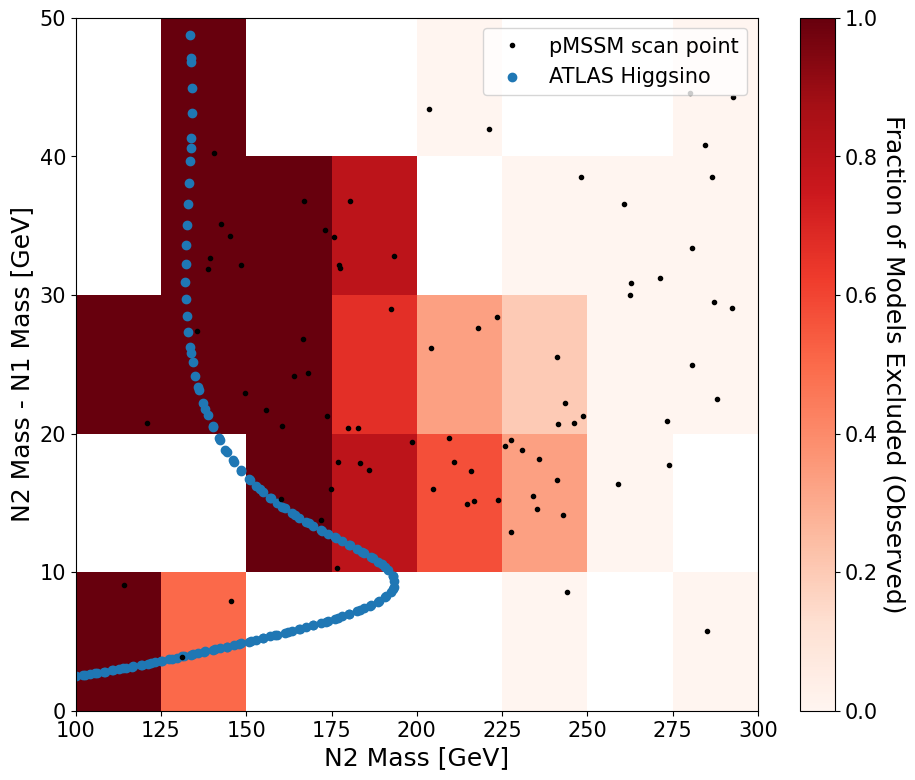

In [13]:
makepmssmsummaryplot("observed",False)